# Quick Start Guide
This notebook demonstrates the core functionality of the BioNeuralNet package. It covers data loading, network generation, network embedding via GNNs, subject representation, downstream disease prediction, evaluation metrics, clustering, and use of external tools."

## BioNeuralNet provides tools for downstream analysis, preprocessing, clustering, and interpretation in multi-omics workflows.

In [ ]:
from bioneuralnet.downstream_task import SubjectRepresentation
from bioneuralnet.downstream_task import DPMON
from bioneuralnet.clustering import CorrelatedPageRank
from bioneuralnet.clustering import CorrelatedLouvain
from bioneuralnet.clustering import HybridLouvain

from bioneuralnet.utils import get_logger
from bioneuralnet.utils import rdata_to_df
from bioneuralnet.utils import variance_summary
from bioneuralnet.utils import zero_fraction_summary
from bioneuralnet.utils import expression_summary
from bioneuralnet.utils import correlation_summary
from bioneuralnet.utils import explore_data_stats
from bioneuralnet.utils import preprocess_clinical
from bioneuralnet.utils import clean_inf_nan
from bioneuralnet.utils import select_top_k_variance
from bioneuralnet.utils import select_top_k_correlation
from bioneuralnet.utils import select_top_randomforest
from bioneuralnet.utils import top_anova_f_features
from bioneuralnet.utils import prune_network
from bioneuralnet.utils import prune_network_by_quantile
from bioneuralnet.utils import network_remove_low_variance
from bioneuralnet.utils import network_remove_high_zero_fraction
from bioneuralnet.utils import gen_similarity_graph
from bioneuralnet.utils import gen_correlation_graph
from bioneuralnet.utils import gen_threshold_graph
from bioneuralnet.utils import gen_gaussian_knn_graph
from bioneuralnet.utils import gen_lasso_graph
from bioneuralnet.utils import gen_mst_graph
from bioneuralnet.utils import gen_snn_graph

from bioneuralnet.metrics import omics_correlation
from bioneuralnet.metrics import cluster_correlation
from bioneuralnet.metrics import louvain_to_adjacency
from bioneuralnet.metrics import evaluate_rf
from bioneuralnet.metrics import plot_performance_three
from bioneuralnet.metrics import plot_variance_distribution
from bioneuralnet.metrics import plot_variance_by_feature
from bioneuralnet.metrics import plot_performance
from bioneuralnet.metrics import plot_embeddings
from bioneuralnet.metrics import plot_network
from bioneuralnet.metrics import compare_clusters

from bioneuralnet.datasets import DatasetLoader
from bioneuralnet.external_tools import SmCCNet

import ray
import torch
ray.shutdown()
ray.init()
torch.cuda.empty_cache()

## Load Data

To help you get started, BioNeuralNet includes demo datasets accessible via `DatasetLoader`.  
This makes it easy to explore the toolkit without needing to prepare your own data upfront.


In [2]:
import pandas as pd
from bioneuralnet.datasets import DatasetLoader

Example = DatasetLoader("example1")
omics1 = Example.data["X1"]
omics2= Example.data["X2"]
phenotype = Example.data["Y"]
clinical = Example.data["clinical_data"]

In [3]:
print(omics1)
print(omics2)
print(phenotype)
print(clinical)

             Gene_1     Gene_2     Gene_3     Gene_4     Gene_5     Gene_6  \
Samp_1    22.485701  40.353720  31.025745  20.847206  26.697293  30.205449   
Samp_2    37.058850  34.052233  33.487020  23.531461  26.754628  31.735945   
Samp_3    20.530767  31.669623  35.189567  20.952544  25.018826  32.157235   
Samp_4    33.186888  38.480880  18.897097  31.823300  34.049383  38.799887   
Samp_5    28.961981  41.060494  28.494956  18.374495  30.815238  24.004535   
...             ...        ...        ...        ...        ...        ...   
Samp_354  24.520652  28.595409  31.299666  32.095379  33.659730  29.353948   
Samp_355  31.252789  28.988087  29.574195  31.189288  32.098841  26.849138   
Samp_356  24.894826  25.944887  30.852641  26.705158  30.102546  37.197952   
Samp_357  17.034337  38.574705  25.095201  37.062442  35.417758  29.753145   
Samp_358  20.839167  27.099788  31.038453  19.410859  31.818995  33.493625   

             Gene_7     Gene_8     Gene_9    Gene_10  ...   Gen

## Generating an Omics Network
At its core, BioNeuralNet leverages Graph Neural Networks to power downstream applications via learned embeddings. It supports a range of standard graph construction techniques for omics and other biological entities:

- **Cosine similarity / RBF kernel graphs** (`gen_similarity_graph`)  
- **Pearson / Spearman correlation graphs** (`gen_correlation_graph`)  
- **Soft-threshold (WGCNA-style) graphs** (`gen_threshold_graph`)  
- **Gaussian k-NN graphs** (`gen_gaussian_knn_graph`)  
- **Mutual information graphs** (`gen_mutual_info_graph`)  
- **Graphical Lasso (sparse inverse covariance) graphs** (`gen_lasso_graph`)  
- **Minimum Spanning Tree (MST) graphs** (`gen_mst_graph`)  
- **Shared Nearest Neighbor (SNN) graphs** (`gen_snn_graph`)

For more details on all of these utilities, see the [utils documentation](https://bioneuralnet.readthedocs.io/en/latest/utils.html).  


## Example: Sparse Multiple Canonical Correlation Network Analysis (SmCCNet 2.0)

In this section, we’ll construct phenotype-specific multi-omics networks using **SmCCNet 2.0**, an R-based algorithm developed by the Kechris Lab at the University of Colorado Anschutz Medical Campus. BioNeuralNet provides a lightweight Python wrapper in `bioneuralnet.external_tools.smccnet` to simplify its usage (requires R).

For full details and examples, see the [External Tools documentation](https://bioneuralnet.readthedocs.io/en/latest/external_tools/index.html).

**Install & Resources**  
- CRAN: https://cran.r-project.org/web/packages/SmCCNet/  
- GitHub: https://github.com/KechrisLab/SmCCNet  
- Publication: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-024-05900-9

In [ ]:
from bioneuralnet.external_tools import SmCCNet

smccnet = SmCCNet(
    phenotype_df=phenotype,
    omics_dfs=[omics1, omics2],
    data_types=["genes", "mirna"],
    subSampNum=1000,
)
global_network, clusters = smccnet.run()

In [5]:
print("Global network shape:", global_network.shape)
print("Number of SmCCnet clusters:", len(clusters))
print(global_network.head())

Global network shape: (600, 600)
Number of SmCCnet clusters: 3
          Gene_1    Gene_2  Gene_3  Gene_4    Gene_5    Gene_6    Gene_7  \
Gene_1  0.000000  0.158521       0       0  0.039205  0.264589  0.275125   
Gene_2  0.158521  0.000000       0       0  0.035508  0.220677  0.241428   
Gene_3  0.000000  0.000000       0       0  0.000000  0.000000  0.000000   
Gene_4  0.000000  0.000000       0       0  0.000000  0.000000  0.000000   
Gene_5  0.039205  0.035508       0       0  0.000000  0.057435  0.061737   

        Gene_8    Gene_9   Gene_10  ...  Mir_91  Mir_92  Mir_93  Mir_94  \
Gene_1       0  0.009918  0.041573  ...       0       0       0       0   
Gene_2       0  0.008298  0.034195  ...       0       0       0       0   
Gene_3       0  0.000000  0.000000  ...       0       0       0       0   
Gene_4       0  0.000000  0.000000  ...       0       0       0       0   
Gene_5       0  0.002178  0.009461  ...       0       0       0       0   

        Mir_95    Mir_96  Mir

## Generate Network Embeddings using `GNNEmbedding`

Next, we transform the constructed network into low-dimensional representations using graph neural networks. The `GNNEmbedding` module in BioNeuralNet supports models like GCN and GAT, enabling integration of omics, clinical, and phenotype data into a unified graph framework. These embeddings serve as compact, informative representations of each subject, suitable for downstream tasks such as classification, clustering, and visualization.

In [ ]:
from bioneuralnet.network_embedding import GNNEmbedding

merged_omics = pd.concat([omics1, omics2], axis=1)

gnn = GNNEmbedding(
    adjacency_matrix=global_network,
    omics_data=merged_omics,
    phenotype_data=phenotype,
    clinical_data=clinical,
    phenotype_col="phenotype",
    tune=True,
    gpu=True,
)
gnn.fit()
embeddings = gnn.embed(as_df=True)

In [7]:
print(embeddings.head())

         Embed_1   Embed_2   Embed_3   Embed_4  Embed_5   Embed_6  Embed_7  \
Gene_1  0.622906  1.088935  0.000000  0.328584      0.0  0.331511      0.0   
Gene_2  0.220702  0.648155  0.000000  0.728628      0.0  0.660685      0.0   
Gene_3  0.040889  0.159836  0.201302  0.259079      0.0  0.245108      0.0   
Gene_4  0.069093  0.202269  0.238928  0.302644      0.0  0.328130      0.0   
Gene_5  0.122250  0.234733  0.223143  0.267772      0.0  0.301783      0.0   

        Embed_8   Embed_9  Embed_10  ...  Embed_503  Embed_504  Embed_505  \
Gene_1      0.0  0.131369       0.0  ...        0.0   0.000000   0.502702   
Gene_2      0.0  0.408497       0.0  ...        0.0   0.158637   1.006010   
Gene_3      0.0  0.239099       0.0  ...        0.0   0.170942   0.363268   
Gene_4      0.0  0.251287       0.0  ...        0.0   0.202546   0.503501   
Gene_5      0.0  0.215249       0.0  ...        0.0   0.123750   0.482375   

        Embed_506  Embed_507  Embed_508  Embed_509  Embed_510  Embed

### Embeddings visualization

In [ ]:
from bioneuralnet.metrics import plot_embeddings

# Using our embeddings instance we get the necessary labels for the graph.
node_labels = gnn._prepare_node_labels()
embeddings_array = embeddings.values  

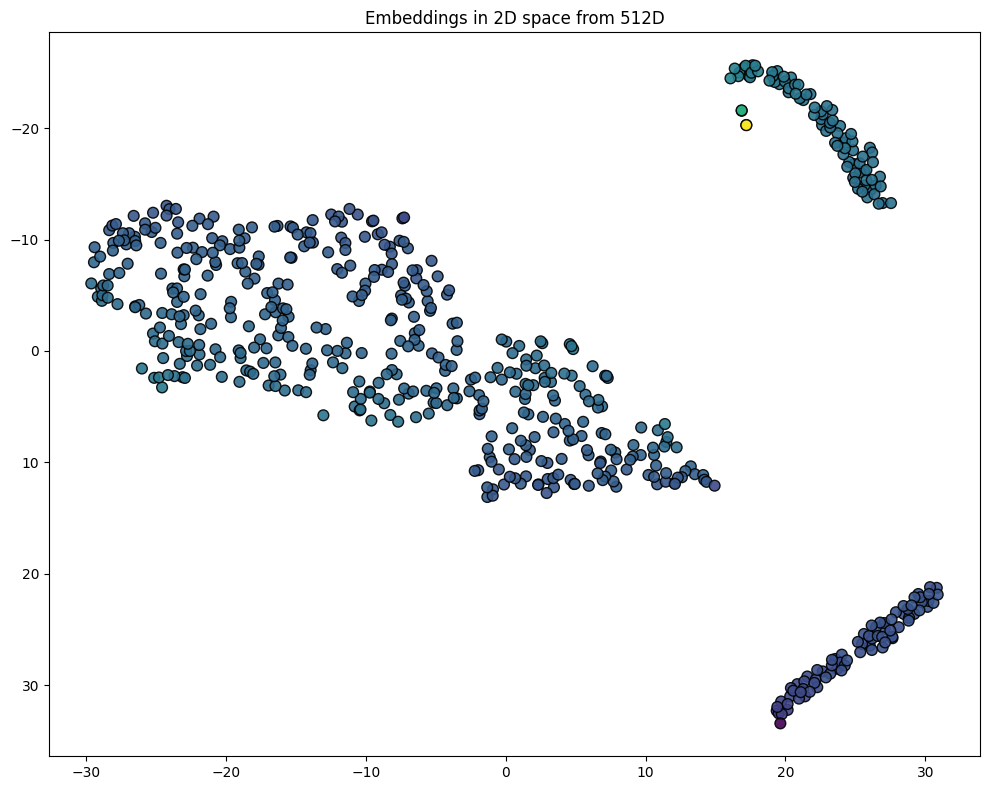

In [9]:
embeddings_plot = plot_embeddings(embeddings_array, node_labels)

## Embedding Interpretation Notes

We projected the 512‑dimensional node embeddings into 2‑D and observed three clear regions plus one broad cloud.
The class buckets (after binning the continuous phenotype into four equal‑frequency groups) contain:

| Bucket | Samples |
| ------ | ------- |
| 0      | 38      |
| 1      | 158     |
| 2      | 141     |
| 3      | 21      |

## Visual observations

- **Middle‑left cloud**

  - Largest and most diffuse region
  - Contains the majority of points
  - Most likely accounting for buckets 1 and 2

- **Top‑right hand oval**

  - Compact cluster on the far right
  - Roughly forty points
  - Could be bucket 0 or 3

- **Lower-right hand cluster**

  - Compact group far below the main cloud
  - Also around forty points
  - Could be bucket 0 or 3


### Integrate Embeddings into Omics Data with SubjectRepresentation

- Let use these omics to enrich the representation of the original dataset.

- The `SubjectRepresentation` function takes our previously generated embeddings and our original Omics Dataset and associated Phenotype

- This function will use the embeddings to enrich the orignal dataset. For more details and how this is performed please view our `GNN Embeddings for Multi-Omics` tab.

In [ ]:
from bioneuralnet.downstream_task import SubjectRepresentation

graph_embed = SubjectRepresentation(
    omics_data=merged_omics,
    embeddings=embeddings,
    phenotype_data=phenotype,
    phenotype_col="phenotype",
    tune=True,
)
enhanced_omics = graph_embed.run()

In [ ]:
print("Before graph embedding:")
print(merged_omics.head())

Before graph embedding:
           Gene_1     Gene_2     Gene_3     Gene_4     Gene_5     Gene_6  \
Samp_1  22.485701  40.353720  31.025745  20.847206  26.697293  30.205449   
Samp_2  37.058850  34.052233  33.487020  23.531461  26.754628  31.735945   
Samp_3  20.530767  31.669623  35.189567  20.952544  25.018826  32.157235   
Samp_4  33.186888  38.480880  18.897097  31.823300  34.049383  38.799887   
Samp_5  28.961981  41.060494  28.494956  18.374495  30.815238  24.004535   

           Gene_7     Gene_8     Gene_9    Gene_10  ...    Mir_91    Mir_92  \
Samp_1  23.512005  33.677622  19.430333  30.260153  ...  7.551462  5.407878   
Samp_2  22.795952  29.301536  14.936397  30.823015  ...  6.862413  7.309226   
Samp_3  25.069464  22.853719  18.220225  23.092805  ...  6.874958  7.754733   
Samp_4  24.106468  12.397175  13.724255  27.703085  ...  9.615623  6.693593   
Samp_5  29.616296  24.364045  11.409338  33.599828  ...  9.146865  8.104206   

           Mir_93     Mir_94     Mir_95     

In [21]:
print("After graph embedding:")
print(enhanced_omics.head())

After graph embedding:
          Gene_1    Gene_2     Gene_3     Gene_4     Gene_5    Gene_6  \
Samp_1  3.275255  4.058951  24.253431  18.906920  12.713527 -6.038568   
Samp_2  5.397971  3.425120  26.177458  21.341346  12.740831 -6.344540   
Samp_3  2.990500  3.185467  27.508372  19.002453  11.914224 -6.428763   
Samp_4  4.833983  3.870573  14.772230  28.861449  16.214669 -7.756739   
Samp_5  4.218586  4.130041  22.275064  16.664348  14.674535 -4.798903   

           Gene_7     Gene_8    Gene_9   Gene_10  ...    Mir_91    Mir_92  \
Samp_1  15.377008  33.241893  9.982780 -4.382418  ...  2.612755  6.583798   
Samp_2  14.908705  28.922426  7.673917 -4.463934  ...  2.374349  8.898587   
Samp_3  16.395597  22.558033  9.361059 -3.344409  ...  2.378689  9.440967   
Samp_4  15.765791  12.236778  7.051151 -4.012091  ...  3.326941  8.149086   
Samp_5  19.369255  24.048818  5.861809 -4.866085  ...  3.164754  9.866431   

           Mir_93    Mir_94     Mir_95    Mir_96    Mir_97     Mir_98  \
Sa

## Disease Classification with DPMON (Disease Prediction using Multi-Omics Networks)

DPMON extends BioNeuralNet’s embedding pipeline for disease classification tasks. Unlike standard node-level GNN objectives (e.g., regression on network properties), DPMON:

- Combines node embeddings with patient-level omics data, capturing both local and global biological signals.
- Uses a classification head (e.g., a softmax layer with cross-entropy loss) to predict discrete disease classes.
- Enables end-to-end training, leveraging GNN-extracted structure and omics context for sample-level prediction.

In this example, we convert the continuous phenotype into 4 discrete classes (0–3) to train a multi-class classifier.

In [12]:
from bioneuralnet.datasets import DatasetLoader
import numpy as np

Example = DatasetLoader("example1")
omics1 = Example.data["X1"]
omics2 = Example.data["X2"]
phenotype = Example.data["Y"]
clinical = Example.data["clinical_data"]

min_val = phenotype["phenotype"].min()
max_val = phenotype["phenotype"].max()

# linspace creates an array of evenly spaced values
bins = np.linspace(min_val, max_val, 5)

phenotype["phenotype"] = pd.cut(phenotype["phenotype"], bins=bins, labels=[0, 1, 2, 3], include_lowest=True)
count_values = phenotype["phenotype"].value_counts(sort=False)

In [13]:
# After binning
print(phenotype)
print(count_values)

         phenotype
Samp_1           1
Samp_2           2
Samp_3           1
Samp_4           3
Samp_5           2
...            ...
Samp_354         1
Samp_355         1
Samp_356         2
Samp_357         1
Samp_358         1

[358 rows x 1 columns]
phenotype
0     38
1    158
2    141
3     21
Name: count, dtype: int64


## DPMON Example

In this example, we run **DPMON** in a loop for 3 runs to evaluate its classification performance.

For each run:
- We instantiate a new `DPMON` model with the same inputs: omics data, phenotype, clinical data, and global network.
- Set repeat_num = 3, which instructs DPMON to perform three internal iterations. In each iteration it trains an independent model
- We call `.run()` to generate predictions.
- We extract the predicted and actual labels.
- We compute three classification metrics:
  - **Accuracy**
  - **F1-Weighted**
  - **F1-Macro**

After the 3 runs are complete, we calculate the **mean** and **standard deviation** of each metric. These summary statistics allow us to compare DPMON's performance fairly against other models like Random Forest, using consistent metrics and repeated evaluation.

This setup mimics the structure used for other models in the framework, ensuring that DPMON is evaluated in a reproducible and statistically robust way.


In [ ]:
from bioneuralnet.downstream_task import DPMON
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

acc_scores = []
f1w_scores = []
f1m_scores = []

for i in range(3):
    print(f"DPMON run {i+1}")
    
    dpmon = DPMON(
        adjacency_matrix=global_network,
        omics_list=[omics1, omics2],
        phenotype_data=phenotype,
        clinical_data=clinical,
        repeat_num=3,
        tune=True,
        gpu=True,
        cuda=0,
        output_dir="dpmon_output"
    )
    
    predictions_df = dpmon.run()
    y_true = predictions_df[0]["Actual"]
    y_pred = predictions_df[0]["Predicted"]

    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    f1m = f1_score(y_true, y_pred, average="macro")

    acc_scores.append(acc)
    f1w_scores.append(f1w)
    f1m_scores.append(f1m)

# get the mean and std in tuple form
dpmon_acc_tuple = (np.mean(acc_scores), np.std(acc_scores))
dpmon_f1w_tuple = (np.mean(f1w_scores), np.std(f1w_scores))
dpmon_f1m_tuple = (np.mean(f1m_scores), np.std(f1m_scores))

## Visualizing Results

We now visualize the performance of DPMON compared to a baseline Random Forest using raw omics data.

The metrics shown include:
- **Accuracy**
- **F1-Weighted**
- **F1-Macro**

Each bar represents the mean score across runs, with error bars indicating the standard deviation.

Below, we construct a metrics dictionary and call `plot_multiple_metrics()` to generate the comparison plots.


2025-05-23 12:30:44,555 - bioneuralnet.metrics.plot - INFO - Plotting multiple metrics: ['Accuracy', 'F1-Weighted', 'F1-Macro']


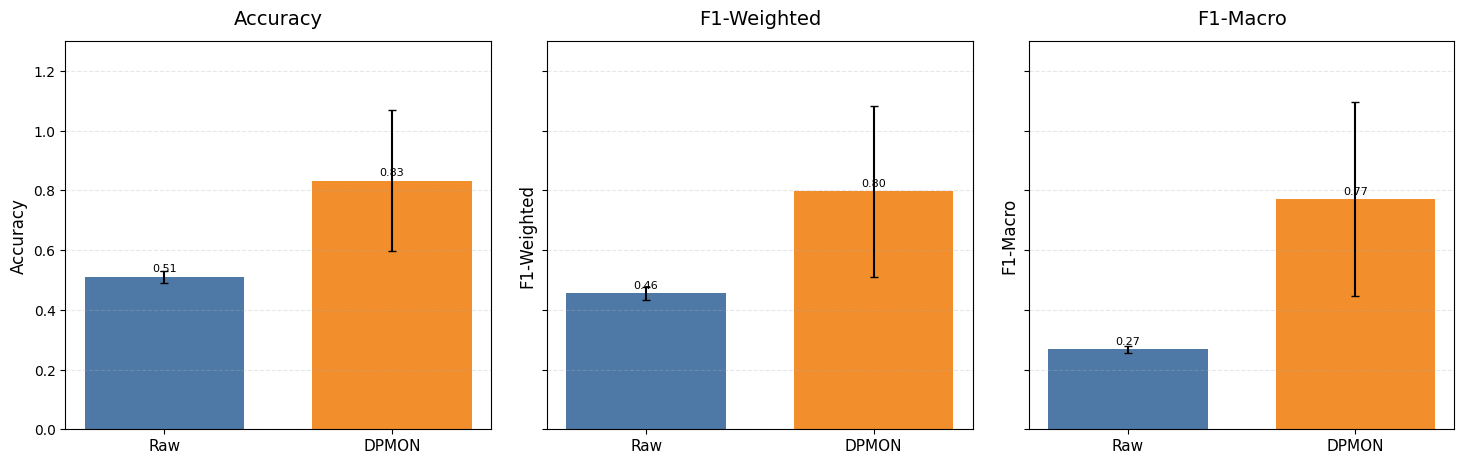

In [23]:
from bioneuralnet.metrics import evaluate_rf, plot_multiple_metrics

# raw omics evaluation
X_raw = merged_omics.values
y_global = phenotype.values
rf_acc, rd_f1w, rf_f1m = evaluate_rf(X_raw, y_global, n_estimators=100, runs=5, mode="classification")

# metrics dictionary
metrics = {
    "Accuracy": {"Raw": rf_acc,"DPMON": dpmon_acc_tuple},
    "F1-Weighted": {"Raw": rd_f1w,"DPMON": dpmon_f1w_tuple},
    "F1-Macro": {"Raw": rf_f1m, "DPMON": dpmon_f1m_tuple}
}

plot_multiple_metrics(metrics)

### Clustering with CorrelatedLouvain and HybridLouvain

- BioNeuralNet includes internal modules for performing correlated clustering on complex networks. 

- These methods modify and extend the traditional community detection by integrating phenotype correlation, allowing users to extract biologically relevant, phenotype-associated modules from any network. 

- For more details on how this performed, please visit our `Correlated Clustering Methods` tab

In [ ]:
from bioneuralnet.clustering import  HybridLouvain
import networkx as nx

merged_omics = pd.concat([omics1, omics2], axis=1)
G_network = nx.from_pandas_adjacency(global_network)

hybrid = HybridLouvain(
    G=G_network,
    B=merged_omics,
    Y=phenotype,
    tune=True,
)
hybrid_result = hybrid.run(as_dfs=True)

Number of clusters: 2


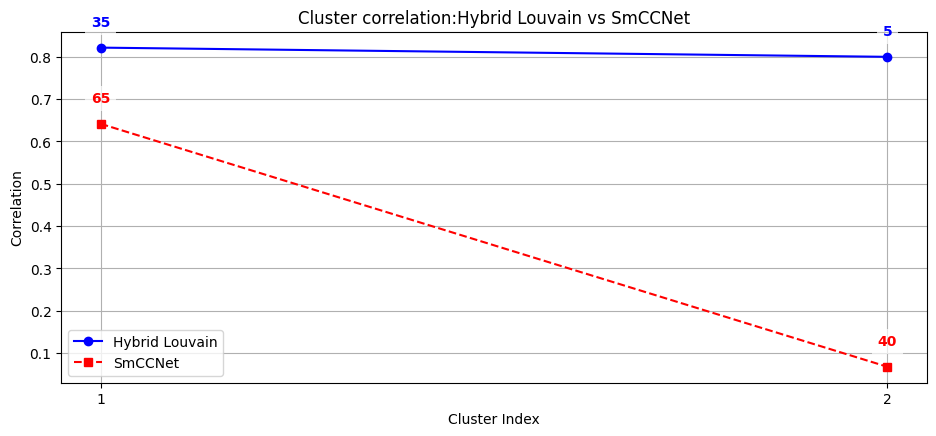

,Cluster,Louvain Size,Louvain Correlation,SMCCNET Size,SMCCNET Correlation
0,Cluster_1,35,0.821929,65,0.641804
1,Cluster_2,5,0.800173,40,0.067307


In [24]:
# Lets compare hytbrid louvain with the SmCCNet clusters
print("Number of clusters:", len(hybrid_result))

compare_clusters(hybrid_result, clusters, phenotype, merged_omics)

### Lets plot the clustered network from correlated louvain

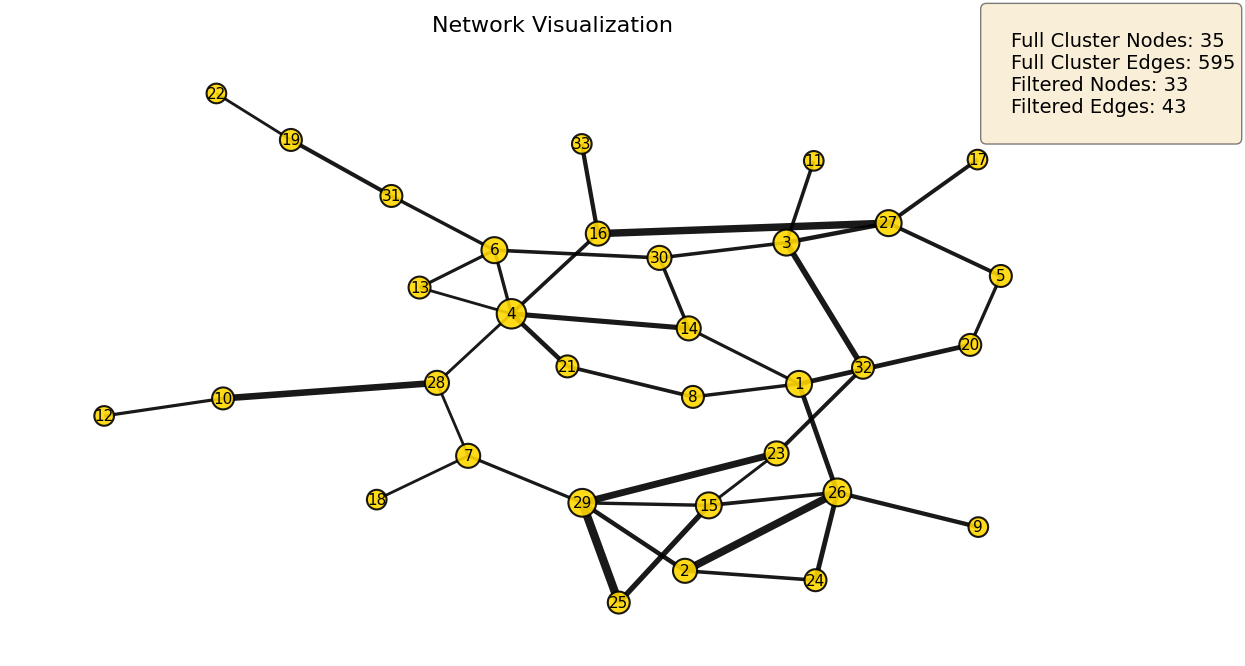

           Omic  Degree
Index                  
4      Gene_411       6
26     Gene_174       5
29       Gene_7       5
27     Gene_367       4
15     Gene_142       4


In [18]:
from bioneuralnet.metrics import plot_network
from bioneuralnet.metrics import louvain_to_adjacency

cluster1 = hybrid_result[0]
cluster2 = hybrid_result[1]

# Convert Louvain clusters into adjacency matrices
louvain_adj1 = louvain_to_adjacency(cluster1)
louvain_adj2 = louvain_to_adjacency(cluster2)

# Plot using the converted adjacency matrices

cluster1_mapping = plot_network(louvain_adj1, weight_threshold=0.1, show_labels=True, show_edge_weights=False)
print(cluster1_mapping.head())

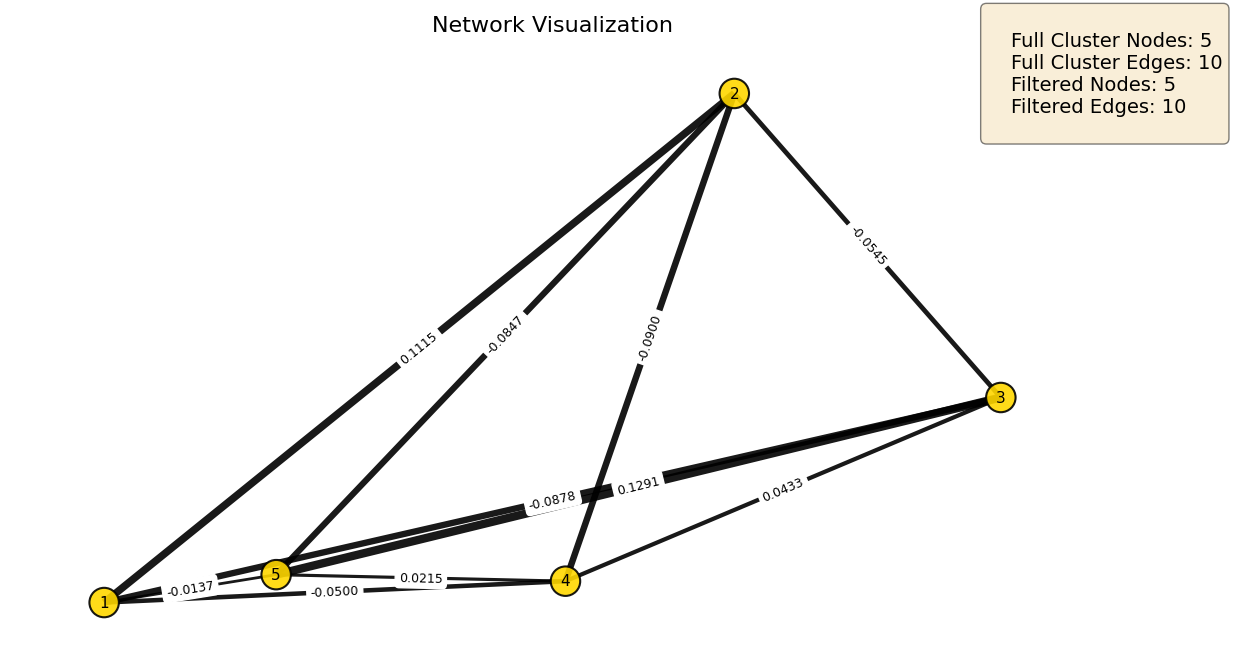

           Omic  Degree
Index                  
1      Gene_446       4
2       Gene_53       4
3        Gene_6       4
4        Gene_1       4
5        Gene_7       4


In [19]:
cluster2_mapping = plot_network(louvain_adj2, weight_threshold=0.01, show_labels=True, show_edge_weights=True)
print(cluster2_mapping.head())

#### Package Version

In [20]:
import bioneuralnet
print("BioNeuralNet version:", bioneuralnet.__version__)

BioNeuralNet version: 1.0.8
